# Modeling a Gene Drive in a Schistosomiasis System

## Summary

As genetic engineering becomes easier and cheaper, its potential for improving global health continues to grow. This theoretical model examines the potential application of a CRISPR-Cas9 gene drive to a population of *Biomphalaria glabrata* snails, the intermediate host for the neglected tropical disease schistosomiasis. This system is of special interest because these snails reproduce both sexually and asexually. This model shows the outcome of a gene drive in a scenario where asexual reproduction has to be considered.

**Tools used in this demo**: Python, pandas, NumPy, matplotlib, sensitivity analysis, population genetics, Markov process, parameter optimization

For more information about this system, see [Grewelle et al. 2022.](https://journals.plos.org/plosntds/article?id=10.1371/journal.pntd.0010894)

Sensitivity analysis code is [avaliable here](https://github.com/ChloeRickards/chloerickards.github.io/blob/master/assets/sensitivity-analysis-snails.py)

# Table of contents
1. [Introduction](#intro)
    1. [About Schistosomiasis](#about-schisto)
    2. [Interventions](#interventions)
    3. [Gene Drives](#gene-drives)
2. [Methods](#methods)
    1. [Setup and Model Assumptions](#setup)
    2. [The Transition Matrix](#tm)
    3. [Simulation Code](#simulation)
3. [Results](#results)
    1. [Plotting Out the Genotypes](#plot)
4. [Application](#application)
    1. [Sensitivity Analysis](#sa)


## Introduction <a name="intro"></a>

### About Schistosomiasis <a name="about-schisto"></a>

Schistosomiasis (SHI-stow-so-MY-ah-sis) is a parasitic worm disease that affects over 200 million people a year. Schistosomiasis is most common in areas in sub-Saharan Africa without access to clean water or sanitation.  Schistosomiasis is characterized by high morbidity and relatively low mortality , meaning that people with schistosomiasis becomne chronically ill but don't usually die. Schistosomiasis is considered a Neglected Tropical Disease and a disease of poverty.

The parasitic larvae enter the bloodstream when people come into contact with infested water. Once in the body, the larvae mature into worms, reside in either the urinary or gastrointestinal system, start to lay spiky eggs that are painfully excreted out of the body. When these eggs enter water, they hatch and infect freshwater snails. Inside the snails, the larvae develop until they are ready to emerge and infect humans, thus continuing the worm's life cycle.

### Interventions <a name="interventions"></a>

Schistosomiasis can be prevented in several ways along the schistosome life cycle, as shown in **Figure 1.** Clean water and sanitation prevents worm larvae from reaching humans and prevents egg-infested excrement from reaching the snails, but is difficult to implement. Adult worms in humans can be treated with the anti-parasite drug praziquantel, but this drug does not prevent reinfection from contaminated waters. Finally, targeting the intermediate snail host can reduce the amount of worm larvae able to infect humans. The snail population can be controlled with molluscicides, habitat control, biological control, and, theoretically, through gene drives.

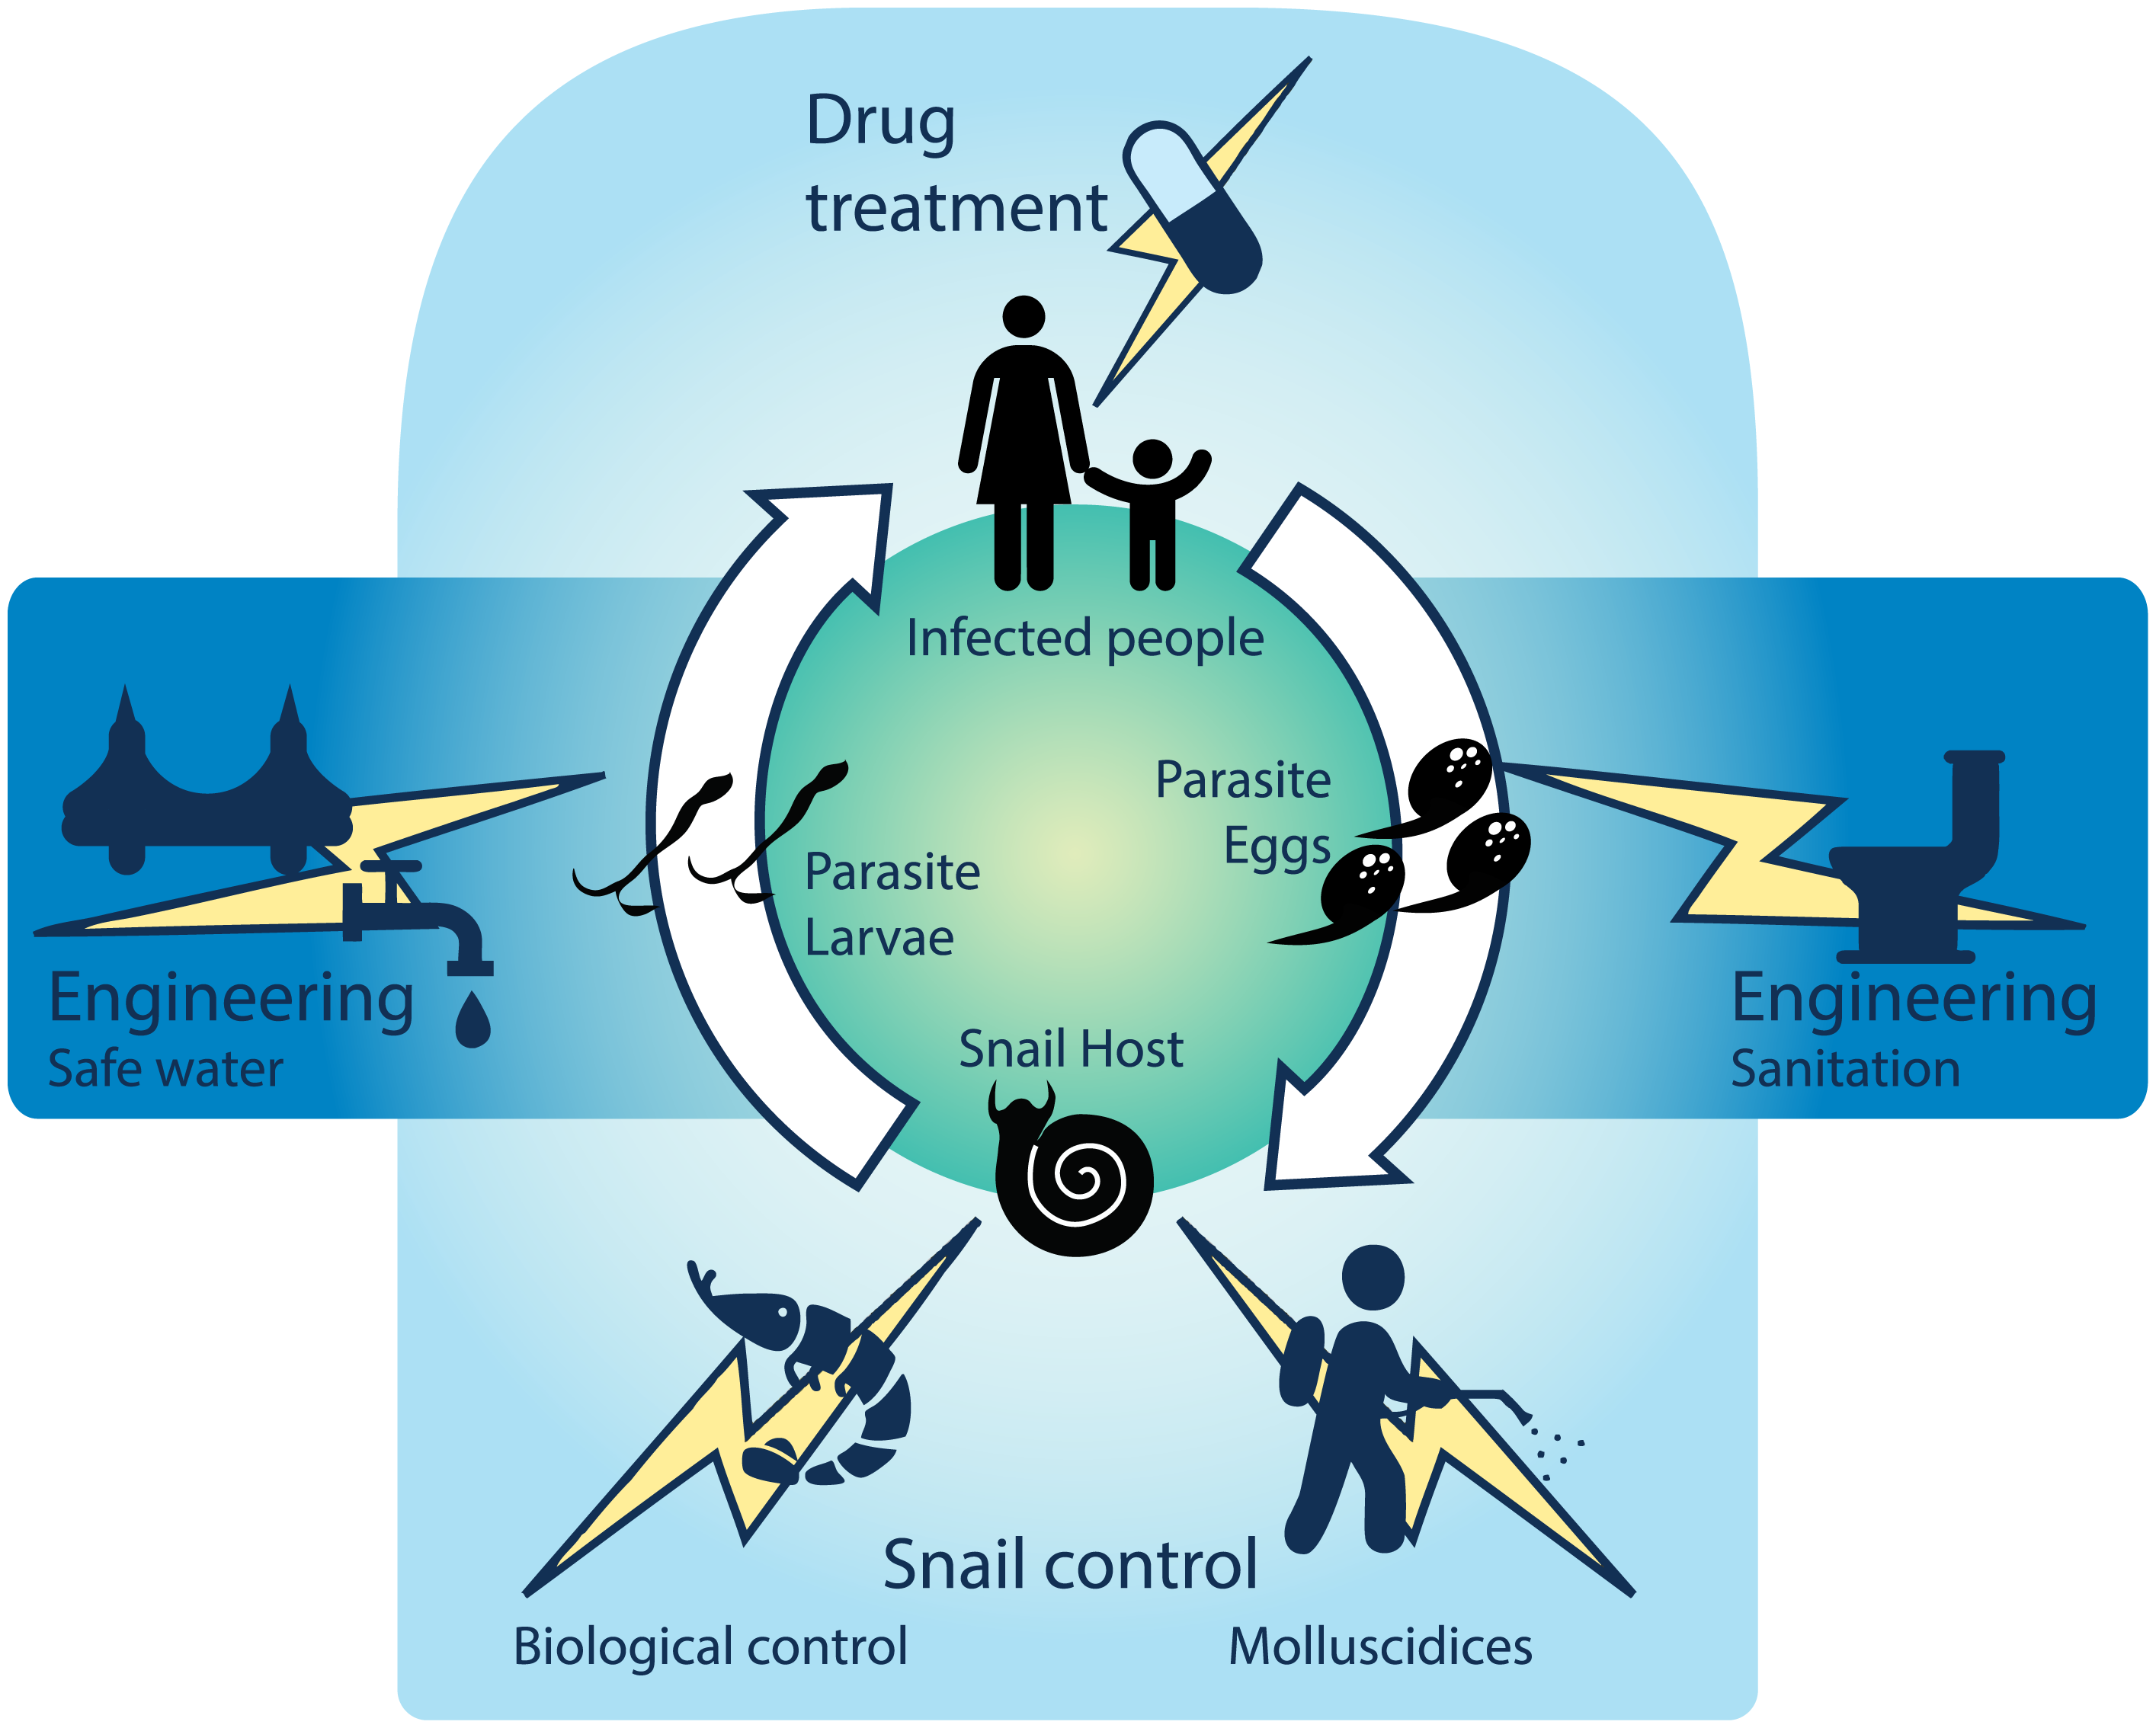

**Figure 1.** Schistosome life cycle, with intervention points labeled as lightning bolts. Reproduced with permission from Sokolow 2016.

### Gene Drives <a name="gene-drives"></a>

Gene drives propagate a target gene through a population at a rate higher than the expected level of Mendelian inheritance. For example, let's say that Parent 1 carries Gene A and Parent 2 carries Gene G. Normally, the chance of inheriting Gene G from a parent is 50%, but if a gene drive is paired with Gene G, the chance becomes much higher - often close to 100%. With the advent of CRISPR/Cas9 gene editing technology, many different gene drive constructs are being explored within the realm of infectious disease control. Some gene drives focus on spreading a lethal gene through, for example, a mosquito population - acting as a sort of genetic pesticide and locally crashing a population. Other gene drives focus on spreading disease resistance through a population, making a disease less transmissible to humans, but otherwise leaving the population mostly intact.

Here, we explore the second scenario within the intermediate snail host of schistosomiasis, as shown in **Figure 2.** These snails exhibit a behavior called *selfing,* a type of asexual reproduction, so one of the goals of this modeling exercise is to see how selfing impacts gene drive outcomes.

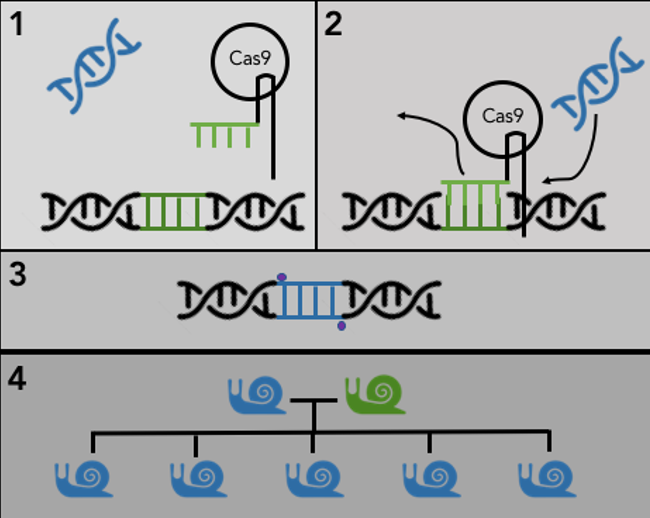

**Figure 2.** CRISPR-Cas9-intermediated gene drive in the intermediate snail host for schistosomiasis. 1) The Cas9 construct is paired with a desired gene and inserted into the snail. 2) Cas9 and the guide RNA pair to its complementary DNA strand, creating a gap where the desired gene can be inserted. 3) The desired gene is now fully inserted into the genome, and enzymes heal the cuts. 4) Snails carrying the Cas9 construct and desired gene mate with wild type snails, such that all (or nearly all) of the offspring carry both the gene drive and desired gene. The desired gene makes its way through the snail population at super-Mendelian rates (i.e. >50% inheritance rates).

To put it another way, let's say we have a wild-type snail with genotype AA mate with an engineered snail of genotype GG. With normal inheritance rules, and using Punnett square logic, we get:

$$AA \times GG \to 100\% AG$$

But with the gene drive, the $A$ allele in the $AG$ genotype becomes overwritten, so all, or nearly all offspring have genotype $GG$

## Methods <a name="methods"></a>

### Setup and Model Assumptions <a name="setup"></a>

To model this situation, we start by establishing some constants. These are the building blocks for this scenario. Where applicable, literature sources for the parameters are listed. These characteristics are specific to *Biomphalaria glabrata.* In this scenario, we have three alleles:

**Allele A:** Mendelian inheritance and no resistance to schistosome infection \
**Allele B:** Mendelian inheritance and resistance to schistosome infection \
**Allele G:** super-Mendelian inheritance and resistance to schistosome infection

Resistance to disease often comes at a cost to fecundity or competitive ability. For this model's purposes, the resistant alleles B and G carry a fitness cost that impacts growth rate. Allele G has an additional fitness cost as a result of carrying the gene drive. Finally, snails that are infected have a severe fitness cost, since schistosome infection castrates the snail.

In [1]:
import numpy as np
import pandas as pd
import math


# Intrinsic growth rate (clutch size), per snail per generation
# Source = Costa 2004
R = 54

# Natural death rate, per generation
# Source = Woolhouse 1991
MU = 0.2

# Gene drive efficiency
# Source = Hammond et al. 2016
G = 0.95

# Selfing rate
# Source = Jarne 1993
SIG = 0.15

# Cost of inbreeding
# Source = Costa 2004
INBR = .85

# Per capita infection rate of snails by a female worm
# Source = Sokolow 2015, then calibrated to expected infection prevalence
BETA = 0.5

# Level of resistance conveyed by both B and G
XI = 0.8

# Carrying capacity
K = 100

# Defining alleles
alleles = ["A", "B", "G"]
N_ALLELES = len(alleles)
allele_growth_rates = [R, R*0.9, R*0.8] # B's growth rate is 90% of A. G's is 80% of A
allele_resistances = [0, XI, XI] # B and G assumed to convey the same resistance

# Defining genotypes from alleles
genotypes = []
genotype_growth_rates = []
genotype_resistances = []
for i in range(0, N_ALLELES):
    for j in range(i, N_ALLELES):
        genotypes.append(alleles[i]+alleles[j])
        genotype_growth_rates.append(np.mean([allele_growth_rates[i],
                                              allele_growth_rates[j]]))
        genotype_resistances.append(np.mean([allele_resistances[i],
                                             allele_resistances[j]]))
N_GENOTYPES = len(genotypes)

# Population dynamics setup
# Number of snail generations to track. Default = 100
N_GENS = 100

# Define initial (starting) snail population for the genotypes [AA, AB, AG, BB, BG, GG]
# Assuming we seed a population with 1 gene drive individual, Default = [49, 20, 0, 30, 0, 1]
initial_pop = [49, 20, 0, 30, 0, 1]

# Define the population genetics matrix. We'll use this to graph out the population over several generations
population_genetics = np.zeros([N_GENOTYPES, N_GENS])

# Initialize the population
population_genetics[:,0] = initial_pop

# Creating an empty array for the number of infected snails
infected_snails = np.zeros((N_GENS, N_GENOTYPES))
for x in range(0, N_GENOTYPES):
    infected_snails[0][x] = (1 - MU) * BETA * (1 - genotype_resistances[x]) * initial_pop[x]

Now let's take a look at the characteristics of the genotypes we are working with:

In [2]:
# View characteristics of the genotypes we are working with
gdf = pd.DataFrame({"Growth Rate": genotype_growth_rates,
                   "Resistance": genotype_resistances})
gdf.index = genotypes
gdf

,Growth Rate,Resistance
AA,54.0,0.0
AB,51.3,0.4
AG,48.6,0.4
BB,48.6,0.8
BG,45.9,0.8
GG,43.2,0.8


### The Transition Matrix <a name="tm"></a>

The goal of this model is to observe how the population genetics of a snail population change over time (measured in generations of snails). To do this, we set up a transition matrix (Grewelle et al. 2022), which tracks how genotypes change from one generation to the next. The transition matrix is the probability that the genotypes in the rows will reproduce and make the genotypes in the columns in the subsequent generation. The following function constructs the matrix by examining all combinations of genotype crossings.

In [3]:
def get_transition_matrix(genotypes, previous_gen_proportions):
    # Framing the proportions in a dataframe we can call by genotype
    proportions = pd.DataFrame(previous_gen_proportions, index = genotypes)

    # Outcrossing transition matrix setup
    out_tm = np.zeros((N_GENOTYPES, N_GENOTYPES))
    out_tm = pd.DataFrame(out_tm, index = genotypes, columns = genotypes)

    # Generating the outcrossing transition matrix
    # genotype1 x genotype 2 --> genotype_nextgen
    # Rows: genotype1
    # Columns: genotype_nextgen
    for genotype1 in genotypes:
        for genotype2 in genotypes:
            for allele1 in genotype1:
                for allele2 in genotype2:
                    genotype_nextgen = allele1 + allele2
                    genotype_nextgen = "".join(sorted(genotype_nextgen)) # alphabetize the genotype
                    rate = np.mean([gdf.loc[genotype1]["Growth Rate"], gdf.loc[genotype2]["Growth Rate"]])

                    # Gene Drive Condition:
                    # If the nextgen genotype is heterozygous for the gene drive,
                    # then the efficiency rate g determines the outcomes
                    # - Most form a gene drive genotype 'GG' at a rate g
                    # - Some stay in the nextgen genotype at a rate (1-g)
                    if bool('G' in allele1) != bool('G' in allele2):
                        out_tm["GG"][genotype1] = out_tm["GG"][genotype1] + G * (1 / 4) * rate * proportions.loc[genotype1][0] * proportions.loc[genotype2][0]
                        out_tm[genotype_nextgen][genotype1] = out_tm[genotype_nextgen][genotype1] + (1 - G) * (1 / 4) * rate * proportions.loc[genotype1][0] * proportions.loc[genotype2][0]
                    else:
                        out_tm[genotype_nextgen][genotype1] = out_tm[genotype_nextgen][genotype1] + (1 / 4) * rate * proportions.loc[genotype1][0] * proportions.loc[genotype2][0]

    # Selfing (asexual reproduction) transition matrix setup
    self_tm = np.zeros((N_GENOTYPES, N_GENOTYPES))
    self_tm = pd.DataFrame(self_tm, index = genotypes, columns = genotypes)

    # Generating the selfing transition matrix
    # genotype_self x genotype_self --> genotype_nextgen
    # Rows: genotype_self,
    # Columns: genotype_nextgen
    for genotype_self in genotypes:
        for allele1 in genotype_self:
            for allele2 in genotype_self:

                # Find the genotype we're working with and alphabetize it
                genotype_nextgen = allele1 + allele2
                genotype_nextgen = "".join(sorted(genotype_nextgen))
                rate = gdf.loc[genotype_self]["Growth Rate"]

                # Gene Drive Condition applies
                if bool ('G' in allele1) != bool('G' in allele2):
                    self_tm['GG'][genotype_self] = self_tm['GG'][genotype_self] + G * (1 / 4) * rate * proportions.loc[genotype_self][0]
                    self_tm[genotype_nextgen][genotype_self] = self_tm[genotype_nextgen][genotype_self] + (1 - G) * (1 / 4) * rate * proportions.loc[genotype_self][0]
                else:
                    self_tm[genotype_nextgen][genotype_self] = self_tm[genotype_nextgen][genotype_self] + (1 / 4) * rate * proportions.loc[genotype_self][0]

    # Combine the two transition matrices, applying the selfing rate and the inbreeding cost
    tm = (1 - SIG) * out_tm + SIG * INBR * self_tm

    return tm

### Simulation Code <a name="simulation"></a>

In [ ]:
# Starting with index of 1 because we have generation 0 already defined
for i in range(1, N_GENS):
    # Apply natural death and infection-caused castration to get to the reproducing pool of snails
    reproducing_population = np.zeros(N_GENOTYPES)
    for x in range(0, N_GENOTYPES):
            infected_snails[i][x] = (1 - MU) * BETA * (1 - gdf.loc[genotypes[x]]["Resistance"]) * population_genetics[x, i-1]
            reproducing_population[x] = population_genetics[x, i-1] - MU * population_genetics[x, i-1] - infected_snails[i][x]

    # The last element is the total number of snails in the population
    total_repr_pop = np.sum(reproducing_population)

    # get a proportion - this is now the probability of encountering the genotype during this generation
    genotype_proportions = reproducing_population/total_repr_pop

    tm =  get_transition_matrix(genotypes, genotype_proportions)

    # Find total amount of new growth, by genotype, and in total
    genotype_growth = np.sum(tm)
    growth_total = np.sum(genotype_growth)

    # apply a coefficient for logistic growth
    log_growth_coeff = total_repr_pop * K / (total_repr_pop + (K - total_repr_pop) * math.exp(-growth_total)) - total_repr_pop

    # new population = reproducing (surviving) population + new births
    new_pop = reproducing_population + genotype_growth/growth_total*log_growth_coeff

    population_genetics[:,i] = new_pop

# Convert population genetics to proportions for plotting purposes
for i in range(0, N_GENS):
    population_genetics[:,i] = population_genetics[:,i]/np.sum(population_genetics[:,i])


## Results <a name="results"></a>

### Plotting Out the Genotypes <a name="plot"></a>

Now, we can observe how the genotypes change over several generations. If the gene drive works well, then the proportion of snails homozygous for the gene drive (genotype $GG$) should rise fairly quickly.

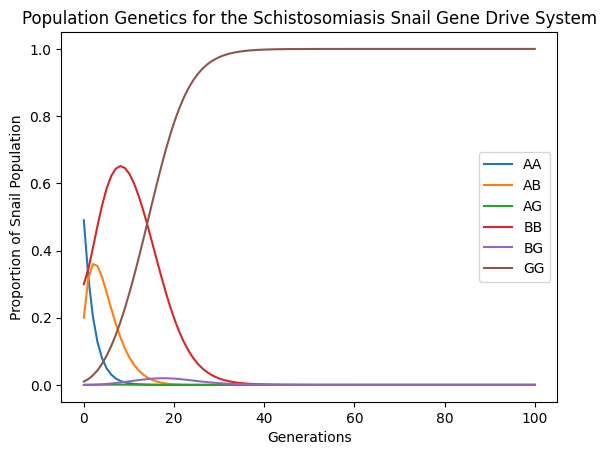

In [5]:
import matplotlib.pyplot as plt

# Make the time axis
t = np.linspace(0, N_GENS, N_GENS)

# Plot each genotype abundance
for x in range(0, N_GENOTYPES):
    plt.plot(t,population_genetics[x,:], label = genotypes[x])
plt.legend()
plt.title("Population Genetics for the Schistosomiasis Snail Gene Drive System")
plt.xlabel("Generations")
plt.ylabel("Proportion of Snail Population")
plt.show()

**Figure 3.** Genotype proportions in a snail population over time. The homozygous gene drive genotype $GG$ rises to fixation within 40 generations. The high infection levels favor the resistant and less costly $BB$ genotype for a while, but the selfish genetic element of the gene drive eventually causes the  genotype to dominate the population. Even though the $G$ allele shares the same level of resistance and incurs more fitness cost than the $B$ allele, the non-Mendelian inheritance pattern of the $G$ allele wins out in the end

We should also observe a decrease in the number of infected snails as time goes on:

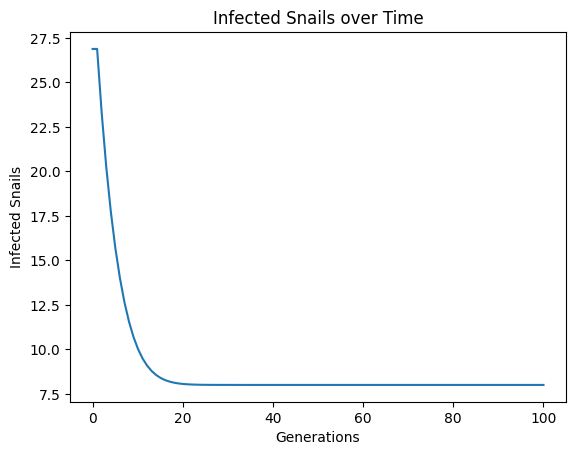

In [6]:
infections_to_plot = np.zeros(N_GENS)
for x in range(0, N_GENS):
    infections_to_plot[x] = np.sum(infected_snails[x,:])

plt.plot(t,infections_to_plot)
plt.xlabel("Generations")
plt.ylabel("Infected Snails")
plt.title("Infected Snails over Time")
plt.show()

# One might ask - why don't snail infections completely drop to 0?
# Answer: while the gene drive may dominate a population, it still only provides partial protection from infection

**Figure 4.** Snail infections over time. Infection drops as the resistant $B$ and $G$ alleles become more common in the population. While these resistant alleles may dominate the population by generation 20, they still only provide a partial protection from infection.

## Application <a name="application"></a>

This exercise demonstrated what would happen to a theoretical population of freshwater snails after a gene drive is introduced to the population. How, then, can we use the information given by this model? One thing we can do is to assess which parameters contribute the most to the success of the gene drive, as measured by the percentage of $GG$ genotype by generation 100.

### Sensitivity Analysis <a name="sa"></a>

To see which parameters have the highest impact on the outcome of the gene drive, we perform a sensitivity analysis. The most sensitive parameters may determine the success or failure of the gene drive. This can give us input about how and where to apply a gene drive. For example, if the most senstive parameters are dependent on external conditions (such as $\beta$, the infection rate; or $r$, the growth rate), then the success of the gene drive may lie in local environmental conditions. If the most sensitive parameters are dependent on genetic conditions (such as $g$, the gene drive efficiency; or $\xi$, the level of disease resistance), then the success of the gene drive may lie in the design of the gene drive itself.

In [ ]:
# This code relies on the package SALib
# The first two lines here are to suppress that warning
# Herman, J. and Usher, W. (2017) SALib: An open-source Python library for sensitivity analysis.
# Journal of Open Source Software, 2(9). doi:10.21105/joss.00097
from SALib.sample import saltelli
from SALib.analyze import sobol


param_ranges = {
    'num_vars': 8,
    'names': ['R',
              'MU',
              'G',
              'SIG',
              'INBR',
              'BETA',
              'XI',
              'K'],
    'bounds': [[20, 80],
               [0.01, 0.4],
               [0.5, 0.99],
               [0.01, 0.3],
               [0.5, 0.99],
               [0.01, 2],
               [0.5, 0.99],
               [50, 150]]
}

# Generate samples
param_values = saltelli.sample(param_ranges, 1024)

Y = np.zeros([param_values.shape[0]])

# Model goes here. To see the full code, visit github link

for i, X in enumerate(param_values):
    # Y[i] is the number of infected snails at the end of the simulation
    Y[i] = evaluate_model(X)

Si = sobol.analyze(param_ranges, Y)

y_pos = np.arange(len(param_ranges['names']))

# plots a bar graph with
#ax.barh(y_pos, Si['ST'], xerr = Si['ST_conf'], align = 'center')
hbars = ax.barh(y_pos, Si['ST'], align = 'center')
ax.set_yticks(y_pos)
ax.set_yticklabels(param_ranges['names'])
ax.invert_yaxis()
ax.bar_label(hbars, fmt='%.2f')
ax.set_ylabel('Parameters')
ax.set_xlabel('Total Sensitivity Index')
plt.show()

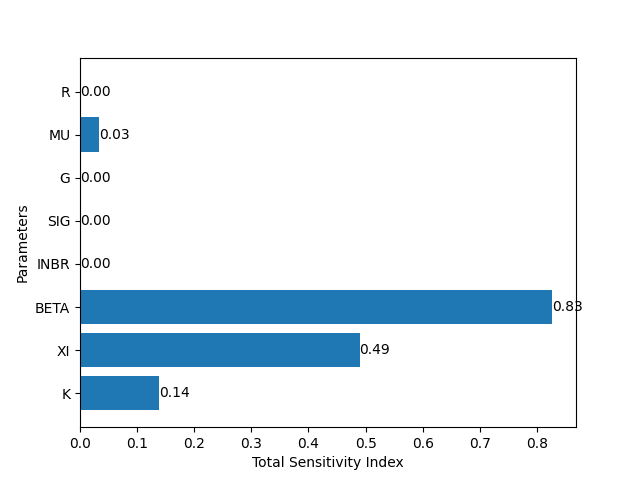

**Figure 5.** Sobol sensitivity analysis, measuring the sensitivity of all of the parameters to the number of infected snails at t=99. The parameter with the highest sensitivity index is beta, or , the force of infection on the snails. This suggests that the higher the infection level in the environment, the more successfully a resistance-inducing gene drive will perform.

### References

Costa MJ, Grault CE, Confalonieri UE. Comparative study of the fecundity and fertility of Biomphalaria glabrata (Say, 1818) and Biomphalaria straminea (Dunker, 1848) in a laboratory through self-fertilization and cross-fertilization. *Rev Inst Med Trop Sao Paulo.* 2004 May-Jun;46(3):157-63. doi: 10.1590/s0036-46652004000300007. Epub 2004 Jul 20. PMID: 15286820.

Grewelle, R.E., Perez-Saez J., Tycko J., Namigai E.K.O., Rickards C.G., De Leo G.A. (2021). Modeling the efficacy of CRISPR gene drive for schistosomiasis control (pre-print). *bioRxiv* 2021.10.29.466423 https://doi.org/10.1101/2021.10.29.466423

Hammond A, Galizi R, Kyrou K, Simoni A, Siniscalchi C, Katsanos D, Gribble M, Baker D, Marois E, Russell S, Burt A, Windbichler N, Crisanti A, Nolan T. A CRISPR-Cas9 gene drive system targeting female reproduction in the malaria mosquito vector Anopheles gambiae. *Nat Biotechnol.* 2016 Jan;34(1):78-83. doi: 10.1038/nbt.3439. Epub 2015 Dec 7. PMID: 26641531; PMCID: PMC4913862.

Jarne, P., & Charlesworth, D. (1993). The Evolution of the Selfing Rate in Functionally Hermaphrodite Plants and Animals. *Annual Review of Ecology and Systematics,* 24, 441–466. http://www.jstor.org/stable/2097186

Sokolow, S. H., Huttinger, E., Jouanard, N., Hsieh, M. H., Lafferty, K. D., Kuris, A. M., Riveau, G., Senghor, S., Thiam, C., N’Diaye, A., Faye, D. S., & De Leo, G. A. (2015). Reduced transmission of human schistosomiasis after restoration of a native river prawn that preys on the snail intermediate host. *Proceedings of the National Academy of Sciences*, 112(31), 9650–9655. https://doi.org/10.1073/pnas.1502651112

Sokolow, S. H., Wood, C. L., Jones, I. J., Swartz, S. J., Lopez, M., Hsieh, M. H., Lafferty, K. D., Kuris, A. M., Rickards, C., & Leo, G. A. D. (2016). Global Assessment of Schistosomiasis Control Over the Past Century Shows Targeting the Snail Intermediate Host Works Best. *PLOS Neglected Tropical Diseases*, 10(7), e0004794. https://doi.org/10.1371/journal.pntd.0004794

Woolhouse, M., Taylor, P., Matanhire, D. et al. Acquired immunity and epidemiology of Schistosoma haematobium. *Nature* 351, 757–759 (1991). https://doi.org/10.1038/351757a0

World Health Organization (2022). Schistosomiasis. Retrieved October 8, 2022, from https://www.who.int/news-room/fact-sheets/detail/schistosomiasis
